# gọi thư viện

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
import re
import string
from tqdm import tqdm
import numpy as np
import os 
import gensim
from gensim.models import KeyedVectors
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import text_dataset_from_directory   # type: ignore
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Đọc DATA và kiểm tra độ lệch của DATA 

In [2]:
path_train = "DATA/data_train/data_train/train"
path_val = "DATA/data_train/data_train/test"
path_test = "DATA/data_test/data_test/test"


train_df = text_dataset_from_directory(path_train,
                                     batch_size=64,
                                     shuffle=True,
                                     seed=123)

val_df = text_dataset_from_directory(path_val,
                                   batch_size=64,
                                   shuffle=False,
                                   seed=123)

test_df = text_dataset_from_directory(path_test,
                                    batch_size=64,
                                    shuffle=False,
                                    seed=123)


print(train_df.class_names, val_df.class_names, test_df.class_names)
print(len(train_df), len(val_df), len(test_df))

Found 30000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
['neg', 'pos'] ['neg', 'pos'] ['neg', 'pos']
469 157 157


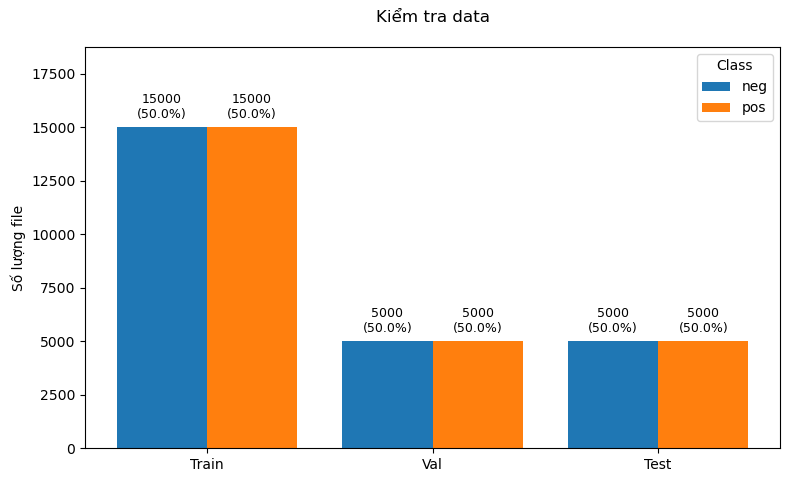

In [3]:
def plot_split_grouped_by_class(base_dir,
                                train_name="train",
                                val_name="test",
                                test_name="test",
                                ext_filter=('.txt',)):
    base = Path(base_dir)
    train_dir = base / "data_train" / "data_train" / train_name
    val_dir   = base / "data_train" / "data_train" / val_name
    test_dir  = base / "data_test"  / "data_test"  / test_name

    def discover_classes(*dirs):
        classes = set()
        for d in dirs:
            if d.exists() and d.is_dir():
                for p in d.iterdir():
                    if p.is_dir():
                        classes.add(p.name)
        ordered = []
        for c in ('neg', 'pos', 'negative', 'positive'):
            if c in classes:
                ordered.append(c)
        # thêm các lớp còn lại
        for c in sorted(classes):
            if c not in ordered:
                ordered.append(c)
        return ordered

    classes = discover_classes(train_dir, val_dir, test_dir)
    if len(classes) == 0:
        print("Không tìm thấy lớp (class) nào. Kiểm tra đường dẫn.")
        return

    def count_in_dir(dir_path, cls):
        p = Path(dir_path) / cls
        if not p.exists():
            return 0
        if ext_filter is None:
            return sum(1 for _ in p.rglob('*') if _.is_file() and not _.name.startswith('.'))
        else:
            return sum(1 for _ in p.rglob('*') if _.is_file() and _.suffix.lower() in ext_filter and not _.name.startswith('.'))

    splits_dirs = [("Train", train_dir), ("Val", val_dir), ("Test", test_dir)]
    counts = []
    for name, d in splits_dirs:
        row = [count_in_dir(d, c) for c in classes]
        counts.append(row)
    counts = np.array(counts)  

    split_totals = counts.sum(axis=1)

    n_splits = counts.shape[0]
    n_classes = counts.shape[1]
    x = np.arange(n_splits)
    width = 0.8 / max(1, n_classes)

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = []
    for j in range(n_classes):
        offsets = x - 0.4 + (j + 0.5) * width
        b = ax.bar(offsets, counts[:, j], width, label=classes[j])
        bars.append(b)

    max_height = int(counts.max() if counts.size else 0)
    top_margin_factor = 1.25
    ax.set_ylim(0, max(1, int(max_height * top_margin_factor)))

    for j, bset in enumerate(bars):
        for i, bar in enumerate(bset):
            h = int(bar.get_height())
            total = split_totals[i]
            pct = (h / total * 100.0) if total > 0 else 0.0
            offset = max(1, int(max_height * 0.02))
            ax.text(bar.get_x() + bar.get_width()/2., h + offset,
                    f"{h}\n({pct:.1f}%)",
                    ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels([s for s, _ in splits_dirs])
    ax.set_ylabel("Số lượng file")
    ax.set_title("Kiểm tra data", pad=18)
    ax.legend(title="Class")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

plot_split_grouped_by_class("DATA")


In [4]:
import random

path_0 = 'DATA/data_train/data_train/train'
path_1 = random.choice(os.listdir(path_0))
path_2 = random.sample(range(len(train_df) * 32), 2)
path_3 = '.txt'

paths = [f"{path_0}/{path_1}/{str(p)}{path_3}" for p in path_2]

for path in paths:
    print(path)
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        print(lines[0])
    else:
        print("File không tồn tại:", path)

DATA/data_train/data_train/train/neg/9850.txt
File không tồn tại: DATA/data_train/data_train/train/neg/9850.txt
DATA/data_train/data_train/train/neg/13388.txt
Khuyên mọi người đừng nên vào khách_sạn này nhé ! Phòng dơ vô_cùng khăn tắm cũ và bị mục rách thản hại ra giường bẩn và dính máu nhưng ở hết 1 đêm kêu nó dọn phòng y_như vẫn ra giường đó ! Và lần đầu_tiên mình thấy có kiểu lúc đặt phòng mình đã ok giá 800.000 và nói rõ phòng 2 người 1 giường lớn k hiểu nó xem kiểu gì ! hôm đó đến còn nói mình k đặt trước và lúc mình lên nhận phòng trong bực_bội thì một lát sau lễ_tân gọi lên nói cho em xin thêm 150k tiền phòng vì ban_đầu cứ tưởng 1 người , mình nói sao lại vậy_thì nó nói chị ơi xem như tiền ăn sáng , đồ_ăn sáng nghèo_nàn , mình quên k chụp ảnh khăn mọi người đừng nên thử k sẽ tiền_mất_tật_mang !



In [5]:
df = pd.read_csv('DATA/Tweets.csv')
df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
2273,569282312203997185,positive,1.000,NaN,NaN,United,NaN,jimccooper,NaN,0,@united thanks ... not sure arranged move to t...,NaN,2015-02-21 15:47:34 -0800,NaN,Eastern Time (US & Canada)
13554,569832733226110976,negative,1.000,Customer Service Issue,0.6283,American,NaN,mas90guru,NaN,0,@AmericanAir how about a reservation phone sys...,NaN,2015-02-23 04:14:45 -0800,"Glastonbury, CT",Eastern Time (US & Canada)
280,568882014415249408,negative,1.000,Lost Luggage,1.0000,Virgin America,NaN,snellbell,NaN,0,@VirginAmerica already contacted Central Bagga...,NaN,2015-02-20 13:16:56 -0800,NaN,Quito
3502,568363838158065664,neutral,0.698,NaN,0.0000,United,NaN,katie_sul1,NaN,0,@united refund?,NaN,2015-02-19 02:57:53 -0800,NaN,Eastern Time (US & Canada)
3277,568558728263254017,negative,1.000,Can't Tell,0.6559,United,NaN,cheryllynnregan,NaN,0,@united Your survey is too long. I fly a lot...,NaN,2015-02-19 15:52:18 -0800,USA,Eastern Time (US & Canada)


In [6]:
df['airline_sentiment'].value_counts(),len(df)

(airline_sentiment
 negative    9178
 neutral     3099
 positive    2363
 Name: count, dtype: int64,
 14640)

# Xử lý các ký tự trong câu

In [7]:
from pyvi import ViTokenizer, ViPosTagger

text = "Tôi đang học xử lý ngôn ngữ tự nhiên"
ViTokenizer.tokenize(text)

'Tôi đang học xử_lý ngôn_ngữ tự_nhiên'

In [8]:
import re
import string
from pyvi import ViTokenizer

# Regex để loại bỏ emoji (các ký tự mặt cười, biểu tượng cảm xúc...)
emoji_pattern = re.compile("[" 
                u"\U0001F600-\U0001F64F"  # emoticons (mặt cười)
                u"\U0001F300-\U0001F5FF"  # biểu tượng & hình vẽ
                u"\U0001F680-\U0001F6FF"  # phương tiện & bản đồ
                u"\U0001F1E0-\U0001F1FF"  # cờ quốc gia
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)



def clean_text(text):
    # 1. loại bỏ đường link
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 2. Chuyển toàn bộ văn bản về chữ thường
    text = text.lower()

    # 3. Loại bỏ emoji
    text = re.sub(emoji_pattern, " ", text)

    # 4. Giảm bớt các ký tự lặp lại liên tiếp (vd: "đẹpppp" -> "đẹp")
    text = re.sub(r'([a-zA-Zàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễ'
                  r'ìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữ'
                  r'ỳýỵỷỹđ])\1+', r'\1', text)

    # 5. Chuẩn hóa khoảng trắng quanh dấu câu
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    # 6. Rút gọn các dấu câu lặp (vd: "!!!" -> "!")
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    # 7. Xóa dấu câu ở đầu và cuối chuỗi
    text = text.strip()
    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]

    # 8. Loại bỏ toàn bộ dấu câu còn sót lại
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 9. Chuẩn hóa nhiều khoảng trắng liên tiếp thành 1 khoảng trắng
    text = re.sub(r"\s+", " ", text)

    # 10. Tách từ bằng Pyvi (ghép từ ghép như "xử lý" -> "xử_lý")
    text = ViTokenizer.tokenize(text)

    return text



In [9]:
sample = "Ối dồi ôiiiiii !!!!!!! Trình là gìiiiiiiiiiii ???  Rồi trình ai chấmmmmm @@ #fail http://x.com"
print(clean_text(sample))

ối dồi ôi trình là gìi rồi trình ai chấm fail


In [10]:
import pandas as pd
import tensorflow as tf

# Hàm tiện ích: đọc dataset TensorFlow -> text và label
def dataset_to_texts_labels(dataset):
    texts = []
    labels = []
    for text_batch, label_batch in dataset:
        for text, label in zip(text_batch.numpy(), label_batch.numpy()):
            texts.append(text.decode("utf-8"))  # chuyển từ bytes -> string
            labels.append(label)
    return texts, labels

# --- Xử lý train ---
train_texts, train_labels = dataset_to_texts_labels(train_df)
train_texts = [clean_text(t) for t in train_texts]

# --- Xử lý val ---
val_texts, val_labels = dataset_to_texts_labels(val_df)
val_texts = [clean_text(t) for t in val_texts]

# --- Xử lý test ---
test_texts, test_labels = dataset_to_texts_labels(test_df)
test_texts = [clean_text(t) for t in test_texts]

train_df_clean = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df_clean   = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df_clean  = pd.DataFrame({"text": test_texts, "label": test_labels})

print(train_df_clean.sample(5))
print(val_df_clean.sample(5))
print(test_df_clean.sample(5))


                                                    text  label
29926  lễ nên chỗ nào cũng ful bàn qua đây mới có bàn...      0
16749  mình mới ghé tuần trước không được ngon lắm mì...      0
18672  quán này ăn có vẻ giống kiểu ở sài_gòn ăn ngon...      0
26894  không bao_giờ quay lạ i nữ a lâ ̀ n đâ ̀ u cu ...      0
10435  mình đã thử được 3 món ở đây mùi_vị rất bình_t...      0
                                                   text  label
1716  quán bày trí thi sơ thức uống nhìn k đẹp giá t...      0
4458  gà đem chiên rồi nấu lẩu ngán không_thể tả nướ...      0
7086  bánh ở đây làm khá ngon hợp_khẩu_vị không quá ...      1
1288  mình ăn quán này vài lần rồi thấy cũng ok tiếc...      0
4426  vô buổi tối 9 10h là khách đông chờ hơi lâu nư...      0
                                                   text  label
2875  từ lúc nghỉ bán ở chợ đêm giờ mới kiếm lại đượ...      0
2794  không bao_giờ quay lạ i phu ̣ c vu ̣ ke ́ m ch...      0
7230  mình đi cùng 3 đứa bạn ghé đây hôm trước tế

In [11]:
train_df_clean.isnull().sum(), val_df_clean.isnull().sum(), test_df_clean.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

In [12]:
train_df_clean.duplicated().sum(), val_df_clean.duplicated().sum(), test_df_clean.duplicated().sum()

(18, 4, 7)

# Mã hóa sang dạng ma trận

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer  # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

def encode_texts_with_tokenizer(train_texts, val_texts, test_texts,
                                train_labels, val_labels, test_labels,
                                num_words=20000, maxlen=100):
    """
    Encode văn bản sang ma trận số bằng TensorFlow Tokenizer.
    - num_words: số từ tối đa giữ lại trong vocab (theo tần suất).
    - maxlen: độ dài chuỗi cố định sau khi pad/truncate.
    """
    # Khởi tạo Tokenizer
    tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
    tokenizer.fit_on_texts(train_texts)

    # Biến văn bản -> sequence số nguyên
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_val_seq   = tokenizer.texts_to_sequences(val_texts)
    X_test_seq  = tokenizer.texts_to_sequences(test_texts)

    # Pad/truncate để có cùng độ dài
    X_train = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
    X_val   = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
    X_test  = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

    # Labels chuyển về numpy array (nếu cần)
    y_train = tf.convert_to_tensor(train_labels, dtype=tf.int32)
    y_val   = tf.convert_to_tensor(val_labels, dtype=tf.int32)
    y_test  = tf.convert_to_tensor(test_labels, dtype=tf.int32)

    return X_train, y_train, X_val, y_val, X_test, y_test, tokenizer


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit(train_texts)
X_train_tfidf = vectorizer.transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)
X_val_tfidf = vectorizer.transform(val_texts)

X_train_tfidf[:1], X_test_tfidf[:1],X_train_tfidf.shape, X_test_tfidf.shape, X_val_tfidf.shape


(<1x31557 sparse matrix of type '<class 'numpy.float64'>'
 	with 103 stored elements in Compressed Sparse Row format>,
 <1x31557 sparse matrix of type '<class 'numpy.float64'>'
 	with 100 stored elements in Compressed Sparse Row format>,
 (30000, 31557),
 (10000, 31557),
 (10000, 31557))

In [15]:
X_train_tfidf.getnnz()

1771628

In [16]:
feature_names = vectorizer.get_feature_names_out()

first_row = X_train_tfidf[0].toarray()

tfidf_features = pd.DataFrame(first_row, columns=feature_names)

non_zero_features = tfidf_features.loc[:, (tfidf_features != 0).any(axis=0)]
print(non_zero_features)

       biết      buổi       bãi       bên      bước       bạn    bảo_vệ  \
0  0.059526  0.076413  0.119264  0.186728  0.089402  0.096242  0.102276   

   bấn_loạn      cafe   chia_sẻ  ...        xe  yêu_sách        đi      đáng  \
0  0.198559  0.083683  0.136488  ...  0.127326  0.188625  0.121653  0.082421   

        đây        đã      được       đến        đồ        ổn  
0  0.075935  0.054463  0.128537  0.045259  0.046293  0.071152  

[1 rows x 103 columns]


In [17]:
X_train, y_train, X_val, y_val, X_test, y_test, tokenizer = encode_texts_with_tokenizer(
    train_df_clean["text"].tolist(),
    val_df_clean["text"].tolist(),
    test_df_clean["text"].tolist(),
    train_df_clean["label"].tolist(),
    val_df_clean["label"].tolist(),
    test_df_clean["label"].tolist(),
    num_words=20000,
    maxlen=128   # tùy bạn chọn
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Vocab size:", len(tokenizer.word_index))


X_train shape: (30000, 128)
X_val shape: (10000, 128)
X_test shape: (10000, 128)
Vocab size: 20383


In [18]:
len(train_df.class_names)

2

In [19]:
train_class = to_categorical(train_labels, num_classes=len(train_df.class_names))
val_class = to_categorical(val_labels, num_classes=len(train_df.class_names))
test_class = to_categorical(test_labels, num_classes=len(train_df.class_names))
print(train_class.shape, train_class[:5])
print(val_class.shape, val_class[:5])
print(test_class.shape, test_class[:5])

(30000, 2) [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(10000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(10000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Deep learning

## Khởi tạo mạng nơ-ron

In [21]:
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout , BatchNormalization, Flatten # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD , Adamax, AdamW  # type: ignore
from tensorflow.keras import backend as K  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # type: ignore

In [22]:
# K.clear_session()
# deep_model = Sequential()

# # Tầng Embedding đầu tiên vì ta đang làm việc với dữ liệu văn bản
# deep_model.add(Embedding(input_dim=20000, output_dim=128, input_length=128))

# # Các tầng LSTM hai chiều để học chuỗi tốt hơn
# deep_model.add(Bidirectional(LSTM(64, return_sequences=True)))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Bidirectional(LSTM(32)))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# # Các tầng Dense cho phân loại
# deep_model.add(Dense(128, activation='relu'))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Dense(64, activation='relu'))
# deep_model.add(BatchNormalization())
# deep_model.add(Dropout(0.3))

# deep_model.add(Dense(1, activation='sigmoid'))

# deep_model.compile(optimizer=Adamax(learning_rate=1e-3),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# deep_model.summary()

In [57]:
from tensorflow.keras.regularizers import l2  # type: ignore
deep_model = Sequential()

deep_model.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
deep_model.add(BatchNormalization())
deep_model.add(Dropout(0.3))

deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(optimizer=Adamax(learning_rate=1e-2),
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │    16,157,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,334,081 (62.31 MB)

 Trainable params: 16,332,161 (62.30 MB)

 Non-trainable params: 1,920 (7.50 KB)

## huấn luyện model

In [24]:
train_class = train_labels
val_class = val_labels
test_class = test_labels

train_class = tf.convert_to_tensor(train_class, dtype=tf.float32)
val_class = tf.convert_to_tensor(val_class, dtype=tf.float32)
test_class = tf.convert_to_tensor(test_class, dtype=tf.float32)

In [25]:
train_labels

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [58]:

stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode ='min',
    verbose=1
)

save = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=20,
    min_lr=1e-8,
    verbose=1
)

his = deep_model.fit(X_train_tfidf,
               train_class,
               epochs=100,
               validation_data=(X_val_tfidf, val_class),
               callbacks=[save, lr],
               steps_per_epoch=len(train_df_clean) // 64,
               verbose=1,
               shuffle=True)

Epoch 1/100
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8234 - loss: 2.2481
Epoch 1: val_loss improved from inf to 0.48378, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.8237 - loss: 2.2330 - val_accuracy: 0.8782 - val_loss: 0.4838 - learning_rate: 0.0100
Epoch 2/100
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9091 - loss: 0.3318
Epoch 2: val_loss improved from 0.48378 to 0.41109, saving model to best_model.h5


468/468 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.9091 - loss: 0.3319 - val_accuracy: 0.8761 - val_loss: 0.4111 - learning_rate: 0.0100
Epoch 3/100
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9238 - loss: 0.2991
Epoch 3: val_loss did not improve from 0.41109
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9238 - loss: 0.2992 - val_accuracy: 0.8742 - val_loss: 0.4170 - learning_rate: 0.0100
Epoch 4/100
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9348 - loss: 0.2700
Epoch 4: val_loss did not improve from 0.41109
468/468 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9348 - loss: 0.2701 - val_accuracy: 0.8682 - val_loss: 0.5042 - learning_rate: 0.0100
Epoch 5/100
462/468 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9532 - loss: 0.2291
Epoch 5: val_loss did not improve from 0.41109
468/468 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.9532 - loss: 0.2292 - val_accuracy: 0.8694 - val_loss: 0.5345 - learning_rate: 0.0100
Epoch 6/100
462/468 ━━━

In [59]:
text = 'quán này phục vụ nhiệt tình đến mức sợ luôn , khách nói tí thì chửi đánh luôn , sợ quá'
def xu_ly(text):
    text = clean_text(text)
    text = vectorizer.transform([text])
    return text

text = xu_ly(text)
kq = deep_model.predict(text)
if kq[0][0] > 0.5:
    print('Comment này được phân loại là: Tích cực')
    confidence = kq[0][0] * 100
else:
    print('Comment này được phân loại là: Tiêu cực')
    confidence = (1 - kq[0][0]) * 100
print("Độ tin cậy:", f"{confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Comment này được phân loại là: Tiêu cực
Độ tin cậy: 87.31%


In [60]:
pd.DataFrame(his.history)

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.850000,1.065669,0.8782,0.483783,1.000000e-02
1,0.904300,0.341669,0.8761,0.411089,1.000000e-02
2,0.920133,0.308641,0.8742,0.416979,1.000000e-02
3,0.932533,0.280261,0.8682,0.504226,1.000000e-02
4,0.949733,0.236916,0.8694,0.534536,1.000000e-02
...,...,...,...,...,...
95,0.999800,0.001957,0.8706,1.083457,9.999999e-07
96,0.999567,0.002375,0.8706,1.084416,9.999999e-07
97,0.999800,0.001876,0.8707,1.087350,9.999999e-07
98,0.999733,0.002338,0.8701,1.081686,9.999999e-07


Độ chính xác của mô hình trên tập huấn luyện: 99.97%
Độ chính xác của mô hình trên tập kiểm tra val: 87.07%


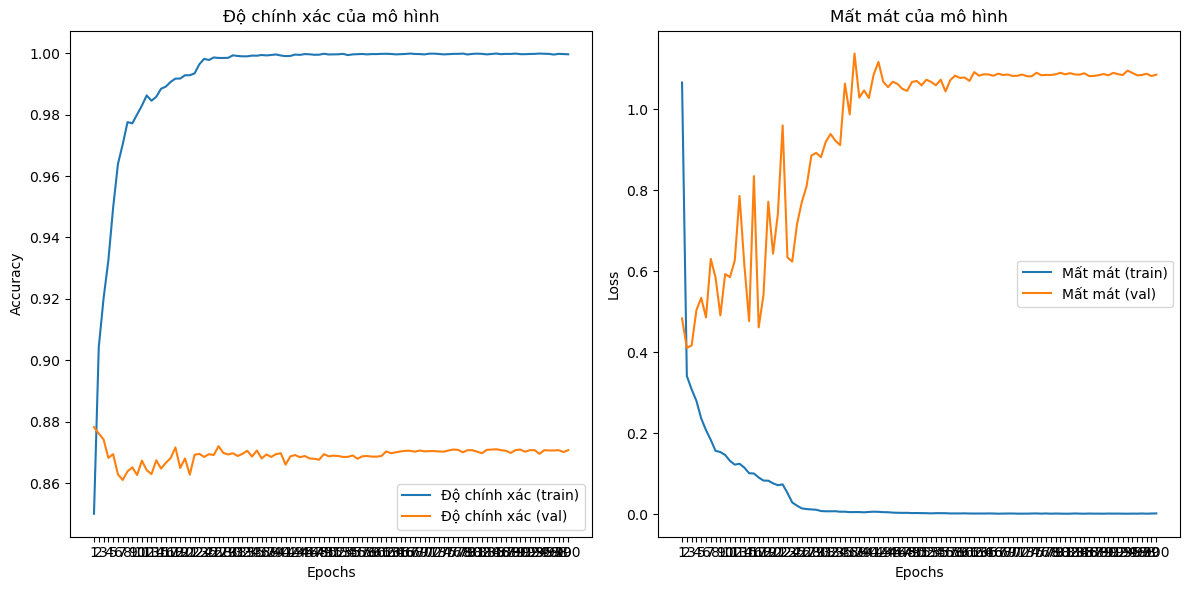

In [61]:
# Độ chính xác của mô hình
print(f"Độ chính xác của mô hình trên tập huấn luyện: {his.history['accuracy'][-1] * 100:.2f}%")
print(f"Độ chính xác của mô hình trên tập kiểm tra val: {his.history['val_accuracy'][-1] * 100:.2f}%")

epochs = range(1, len(his.history['accuracy']) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, his.history['accuracy'], label='Độ chính xác (train)')
plt.plot(epochs, his.history['val_accuracy'], label='Độ chính xác (val)')
plt.title('Độ chính xác của mô hình')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, his.history['loss'], label='Mất mát (train)')
plt.plot(epochs, his.history['val_loss'], label='Mất mát (val)')    
plt.title('Mất mát của mô hình')
plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()


In [30]:
y_test

<tf.Tensor: shape=(10000,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1])>

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Độ chính xác của model: 88.21%


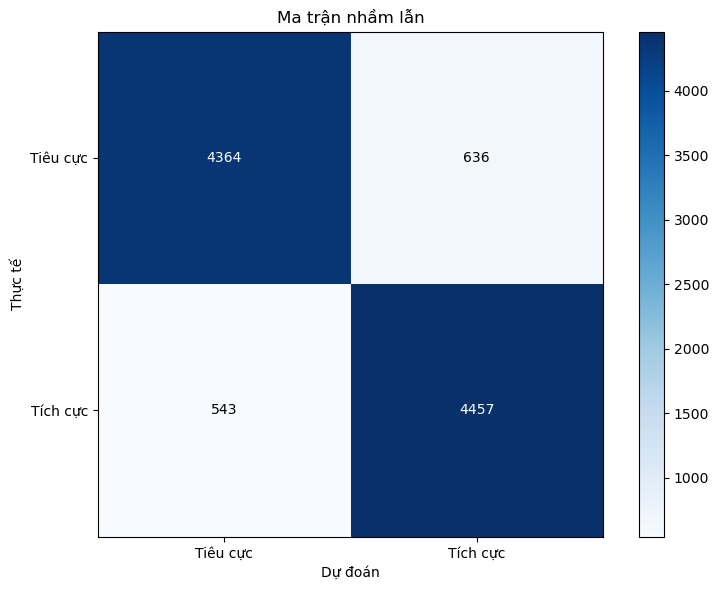

In [62]:
# vẽ ma trận nhầm lẫn
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model  # type: ignore

yred = deep_model.predict(X_test_tfidf)
yred = (yred > 0.5).astype(int)

# độ chính xác trên tập kiểm tra
acc_test = accuracy_score(y_test, yred)
print(f"Độ chính xác của model: {acc_test* 100:.2f}%")

cm = confusion_matrix(y_test, yred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

# Thêm số liệu vào các ô
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Chỉ cần định nghĩa labels một lần
labels = ['Tiêu cực', 'Tích cực']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# Machine learning

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

machine_deep = SVC(C=1,
                   class_weight= None,
                   gamma='scale',
                   kernel='rbf'
                   )
machine_deep.fit(X_train_tfidf, 
                 train_labels)
print('Độ chính xác của model trên tập train:', machine_deep.score(X_train_tfidf, train_labels))
print('Độ chính xác của model trên tập validation:', machine_deep.score(X_val_tfidf, val_labels))
kq_test = machine_deep.predict(X_test_tfidf)
acc_test = accuracy_score(test_labels, kq_test)
print('Độ chính xác của model trên tập test:', acc_test)


Độ chính xác của model trên tập train: 0.9736666666666667
Độ chính xác của model trên tập validation: 0.8861
Độ chính xác của model trên tập test: 0.8942


Độ chính xác của model: 89.42%


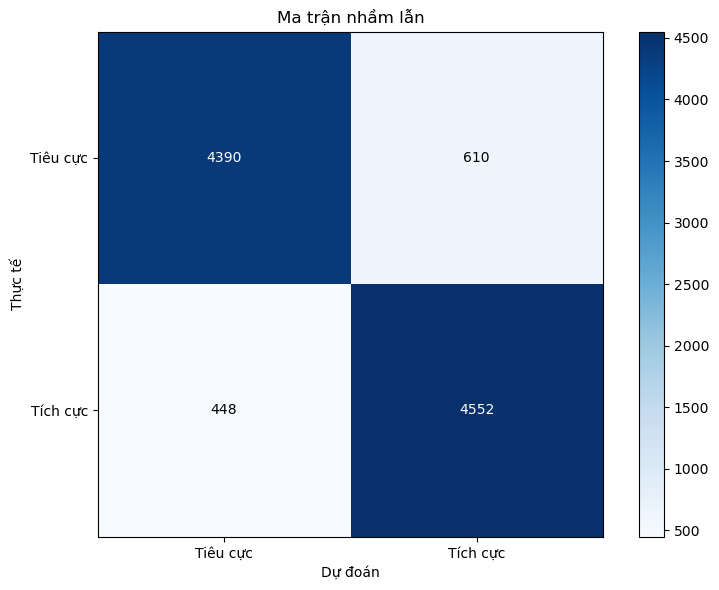

In [33]:
acc_test = accuracy_score(y_test, kq_test)
print(f"Độ chính xác của model: {acc_test* 100:.2f}%")

cm = confusion_matrix(y_test, kq_test)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

# Thêm số liệu vào các ô
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Chỉ cần định nghĩa labels một lần
labels = ['Tiêu cực', 'Tích cực']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

In [ ]:
# import joblib

# joblib.dump(machine_deep, 'MODEL/machine_deep.sav')

['MODEL/machine_deep.sav']

# Test model

### Câu chê:
"Thật sự thất vọng với nhà hàng này khi mọi thứ từ dịch vụ đến chất lượng món ăn đều không đạt kỳ vọng. Không gian quán tuy rộng rãi nhưng lại thiếu sự chăm chút, bàn ghế sắp xếp lộn xộn và không sạch sẽ. Món ăn thì nhạt nhẽo, không có gì đặc sắc, thậm chí một số món còn có cảm giác không tươi mới. Nhân viên phục vụ thiếu chuyên nghiệp, thái độ không thân thiện và thời gian chờ đợi món quá lâu. Với mức giá cao như vậy, tôi nghĩ rằng nhà hàng cần cải thiện rất nhiều để xứng đáng với sự kỳ vọng của khách hàng."

Thật sự 😞 thất vọng vs quán này 👉 https://bit.ly/xyz123 … mọi thứ từ dv 🥲 tới món ăn đều ko đạt 😑. Không gian rộng mà bày biện lộn xộn, bàn ghế còn dính bẩn 🤢. Đồ ăn thì nhạt toẹt, vài món thấy còn ko tươi. Nv thì kiểu khó chịu, gọi 3-4 lần mới ra. Đợi dài cả cổ ⏳. Với giá 💸 như này thì quá chát, chắc chắn ko quay lại 👎.

quán này phục vụ nhiệt tình đến mức sợ luôn , khách nói tí thì chửi đánh luôn , sợ 

### Câu khen:
"Nhà hàng này thực sự là một trải nghiệm ẩm thực đỉnh cao, từ cách bài trí không gian sang trọng, tinh tế cho đến hương vị món ăn được chế biến một cách tỉ mỉ, cầu kỳ. Mỗi món ăn như một tác phẩm nghệ thuật, không chỉ ngon miệng mà còn đẹp mắt, khiến thực khách không thể không trầm trồ. Đội ngũ nhân viên phục vụ chuyên nghiệp, luôn niềm nở và sẵn sàng đáp ứng mọi yêu cầu, tạo cảm giác thoải mái và dễ chịu. Đây chắc chắn là một địa điểm lý tưởng để thưởng thức ẩm thực và tận hưởng những khoảnh khắc đáng nhớ."

Nhà hàng này đúng là trải nghiệm 5⭐ đỉnh thật 😍👉 https://goo.gl/abc456. Không gian sang xịn mịn ✨, bài trí tinh tế. Món ăn thì cực kỳ ngon, trình bày đẹp mắt như nghệ thuật 🎨, ăn vừa ngon vừa thích mắt. Nv phục vụ thì siêu dễ thương 😊, nhiệt tình khỏi chê, hỏi gì cũng hỗ trợ liền. Đi 1 lần là mê, chắc chắn recommend 👍🔥.


In [20]:
from tensorflow.keras.models import load_model  # type: ignore
import joblib

model1 = load_model('MODEL/best_model.h5')
model2 = joblib.load('MODEL/machine_deep.sav')
a = input('Nhập comment của bạn: ')
print('Comment ban đầu:',a)
a = clean_text(a)
print('Comment sau khi xử lý:',a)

a = vectorizer.transform([a])
pred = model1.predict(a)
if pred[0][0] > 0.5:
    confidence = pred[0][0] * 100
    print('Comment này được phân loại là: Tích cực. Độ tin cậy:', f"{confidence:.2f}%")
else:
    confidence = (1 - pred[0][0]) * 100
    print('Comment này được phân loại là: Tiêu cực. Độ tin cậy:', f"{confidence:.2f}%")

kq_test = model2.predict(a)
if kq_test[0] == 1:
    print('Comment này được phân loại là: Tích cực')
else:
    print('Comment này được phân loại là: Tiêu cực')

Comment ban đầu: phục vụ quá kemsmmmmmmmmmmmmmmmmmmmmmmmmm , thất vọng
Comment sau khi xử lý: phục_vụ quá kemsm thất_vọng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Comment này được phân loại là: Tiêu cực. Độ tin cậy: 99.68%
Comment này được phân loại là: Tiêu cực


In [21]:
# df = pd.read_csv('DATA/tập kiểm (data khác).csv')
df = pd.read_csv('DATA/data - data.csv')
df.sample(5)    

,comment,label,rate,Unnamed: 3
1426,"Áo đẹp, hợp giá tiền.",POS,5,NaN
1661,"Mang đi mưa mà vẫn ướt như thường, dây buộc kh...",NEG,1,NaN
29184,Màu tươi.,POS,5,NaN
14282,Quá ưng quá đẹp luôn ạ.,POS,5,NaN
31232,Chất lượng tốt so vs giá tiền.,POS,5,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment     31460 non-null  object
 1   label       31460 non-null  object
 2   rate        31460 non-null  int64 
 3   Unnamed: 3  23 non-null     object
dtypes: int64(1), object(3)
memory usage: 983.3+ KB


In [23]:
df.label.value_counts(), df.rate.value_counts()
# df.Rating.value_counts()

(label
 POS    20093
 NEG     6669
 NEU     4698
 Name: count, dtype: int64,
 rate
 5    13286
 4     6807
 3     4698
 1     3529
 2     3140
 Name: count, dtype: int64)

In [24]:
a = df[df['label']=='NEU']
print(a.sample(1))
a.rate.value_counts()

                                             comment label  rate Unnamed: 3
8993  Chất lượng sản phẩm tạm được, sz ko chuẩn lắm.   NEU     3        NaN


rate
3    4698
Name: count, dtype: int64

In [25]:
a = df[df['label']=='NEG']
print(a.sample(1))
a.rate.value_counts()

                           comment label  rate Unnamed: 3
27968  Thiếu đồ của khách k xử lí.   NEG     1        NaN


rate
1    3529
2    3140
Name: count, dtype: int64

In [26]:
a = df[df['label']=='POS']
print(a.sample(1))
a.rate.value_counts()

                                               comment label  rate Unnamed: 3
30932  Chất lượng tốt, chủ shop nhiệt tình nữa.   POS     5        NaN


rate
5    13286
4     6807
Name: count, dtype: int64

In [27]:
data_test_2 = df[df['label']!='NEU']
print(len(data_test_2))

# data_test_2  = df['Comment'], df['Rating']
# data_test_2 = pd.DataFrame(data_test_2).T
# data_test_2.columns = ['Comment', 'label']
data_test_2.sample(5)

26762


,comment,label,rate,Unnamed: 3
18468,Chất áo cứng quá.,NEG,2,NaN
18579,Chưa biết dùng lâu dài độ bền như nào nhưng sh...,POS,4,NaN
16854,Sp tạm được Shop phục vụ rất tốt.,POS,5,NaN
29066,Áo đúng với giá !,POS,5,NaN
6203,😘😘😘 Shop phục vụ rất tốt.,POS,5,NaN


In [28]:
doi_ten = {'NEG':0, 'POS':1}

data_test_2['label'] = data_test_2['label'].map(doi_ten)
data_test_2 = data_test_2.drop(columns=['rate','Unnamed: 3'])
print(data_test_2.info())
data_test_2.sample(5)

# data_test_2['label'] = data_test_2['label'].astype('Int64')
# data_test_2.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 26762 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  26762 non-null  object
 1   label    26762 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 627.2+ KB
None


,comment,label
7270,Chất lượng sản phẩm tuyệt vời Đóng gói sản phẩ...,1
10306,"Chất lượng áo màu đen khá tốt, rất dày dặn, th...",1
19118,Hình trong đó màu trắng đen nhưng về lại xanh ...,0
13436,"Vải đẹp mịn cực kì luôn, lần thứ 2 mua cực kì ...",1
19735,"Loa nhỏ gọn, ms test trong phòng kín thì rất ok.",1


In [29]:
print(data_test_2.duplicated().sum())
# hiển thị các dòng bị trùng
print(data_test_2[data_test_2.duplicated()])


4078
                                                 comment  label
46                        Chất lượng sản phẩm tuyệt vời.      1
52                                      Giao hàng nhanh.      1
98                        Chất lượng sản phẩm tuyệt vời.      1
119                       Chất lượng sản phẩm tuyệt vời.      1
140                       Thời gian giao hàng rất nhanh.      1
...                                                  ...    ...
31447                                                  .      1
31451  Chất lượng sản phẩm tuyệt vời Đóng gói sản phẩ...      1
31453                                   Giao hàng nhanh.      1
31455                                   Không đáng tiền.      0
31456                                      Quần rất đẹp.      1

[4078 rows x 2 columns]


In [30]:
# xóa các dòng bị trùng
data_test_2 = data_test_2.drop_duplicates()
print(data_test_2.duplicated().sum())
len(data_test_2)

0


22684

In [31]:
data_test_2.isnull().sum()

comment    0
label      0
dtype: int64

In [32]:
data_test_2 = data_test_2.dropna()
data_test_2.isnull().sum()

comment    0
label      0
dtype: int64

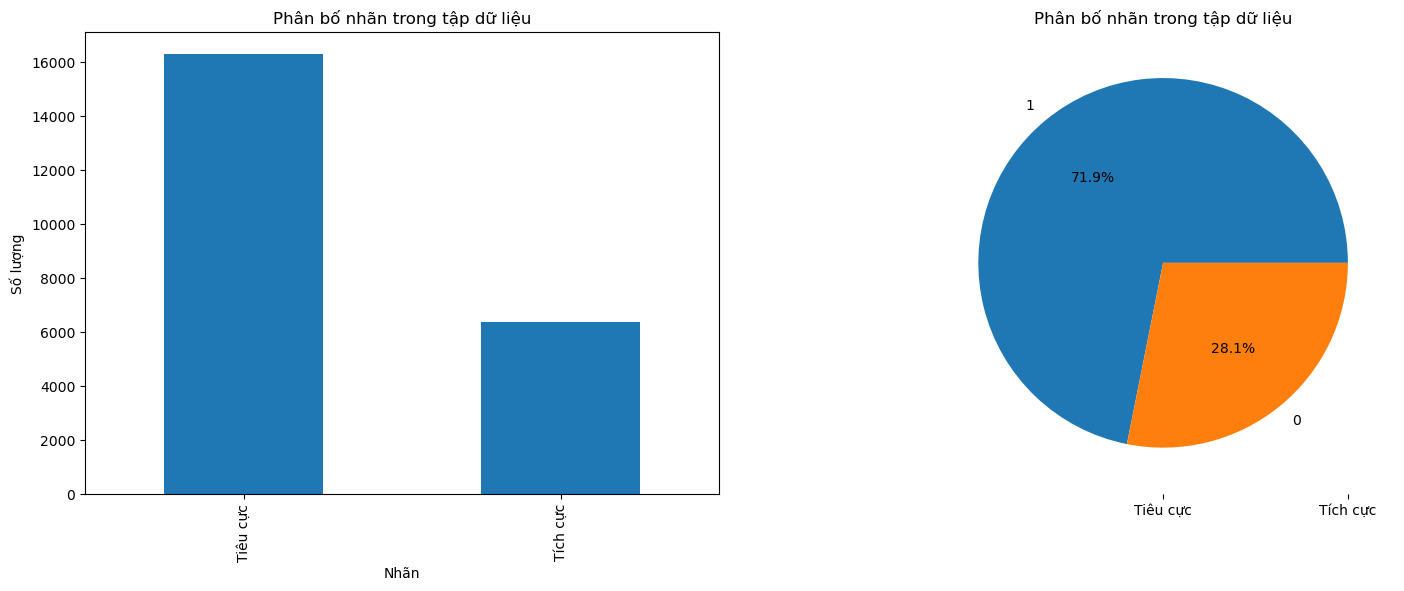

In [33]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
data_test_2['label'].value_counts().plot(kind='bar')
plt.title('Phân bố nhãn trong tập dữ liệu')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
nhan = {0:'Tiêu cực', 1:'Tích cực'}
plt.xticks([0, 1], [nhan[i] for i in [0, 1]])

plt.subplot(1, 2, 2)
data_test_2['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Phân bố nhãn trong tập dữ liệu')
plt.ylabel('')

nhan = {0:'Tiêu cực', 1:'Tích cực'}
plt.xticks([0, 1], [nhan[i] for i in [0, 1]])
plt.show()

In [34]:
text = data_test_2.loc[:, 'comment']
# text = data_test_2.loc[:, 'Comment']
text

0                                           Áo bao đẹp ạ!!
1                                              Tuyệt vời !
2                               2day ao khong giong trong.
3                              Mùi thơm,bôi lên da mềm da.
4                                        Vải đẹp, dày dặn.
                               ...                        
31450    Chất lượng sản phẩm phù hợp vs giá tiền, vải m...
31452                      Chất tốt, Shop phục vụ rất tốt.
31457                              Hàng đẹp đúng giá tiền.
31458                                     Chất vải khá ổn.
31459    áo rất ok nhé , vải mịn , len cao cổ này phối ...
Name: comment, Length: 22684, dtype: object

In [35]:
# nhan = data_test_2.loc[:, 'label']
nhan = data_test_2["label"].values.astype(int)
print(nhan.shape)
print(nhan[:10])

(22684,)
[1 1 0 1 1 1 1 1 1 0]


In [36]:
# xử lý text 
text = [clean_text(t) for t in text]
text

['áo bao đẹp ạ',
 'tuyệt_vời',
 '2day ao khong giong trong',
 'mùi thơm bôi lên da mềm da',
 'vải đẹp dày_dặn',
 'hàng rất đẹp rất chi là ưng_ý',
 'chất_lượng sản_phẩm tốt date dài',
 'ăn_nói và thái_độ phục_vụ tốt',
 'đóng_gói sản_phẩm chắc_chắn',
 'tất sờn hết ca chưa dùng mà vay r',
 'shop phục_vụ rất tốt',
 'chất vải khỏi chê',
 'thời_gian giao hàng rất nhanh',
 'chất_lượng sản_phẩm tuyệt_vời',
 'vải hơi thô cứng thời_gian giao hàng nhanh',
 'chất_lượng sp chưa thật_sự đẹp nhe shop',
 'rất đáng tiền thời_gian giao hàng rất nhanh',
 'quần rất đẹp mặc vừa_vặn',
 'cảm_giác mua hàng bị hớ thật tệ',
 'khi mua về nên đi sửa lại',
 'rất đáng tiền thời_gian giao hàng rất nhanh chất_lượng sản_phẩm tuyệt_vời',
 'giá_cả chấp_nhận được',
 'nchung là rất ổn',
 'áo quá đẹp luôn nếu không muốn nói là đẹp may quá có áo mới đi làm cty mới shop còn mẫu nào trắng nữa để mình mua',
 'chưa mặc nhưng thấy chất dày_dặn nhìn_chung là hài_lòng',
 'chất vải đã ok mà hình thì siu ciu luôn í shop rất nhiệt_tì

In [37]:
text_ma_hoa = vectorizer.transform(text)
text_ma_hoa

<22684x31557 sparse matrix of type '<class 'numpy.float64'>'
	with 186187 stored elements in Compressed Sparse Row format>

In [38]:
from tensorflow.keras.utils import to_categorical  # type: ignore

# giả sử nhan gốc là vector nhãn [0, 1, 0, 1, 1, 0]
print(nhan.shape)  # (n_samples,)
nhan = to_categorical(nhan, num_classes=len(train_df.class_names))
print(nhan.shape)  # (n_samples, num_classes)

(22684,)
(22684, 2)


709/709 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Độ chính xác của model: 73.26%


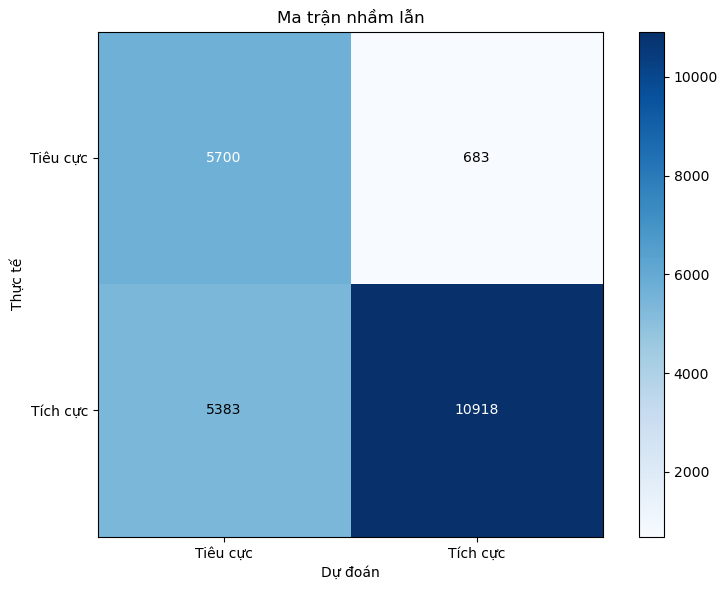

In [39]:
# vẽ ma trận nhầm lẫn
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model  # type: ignore

yred = model1.predict(text_ma_hoa)
yred = (yred > 0.5).astype(int)

nhan_binary = np.argmax(nhan, axis=1)

# độ chính xác trên tập kiểm tra
acc_test = accuracy_score(nhan_binary, yred)
print(f"Độ chính xác của model: {acc_test* 100:.2f}%")

cm = confusion_matrix(nhan_binary, yred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

# Thêm số liệu vào các ô
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Chỉ cần định nghĩa labels một lần
labels = ['Tiêu cực', 'Tích cực']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

Độ chính xác của model: 80.23%


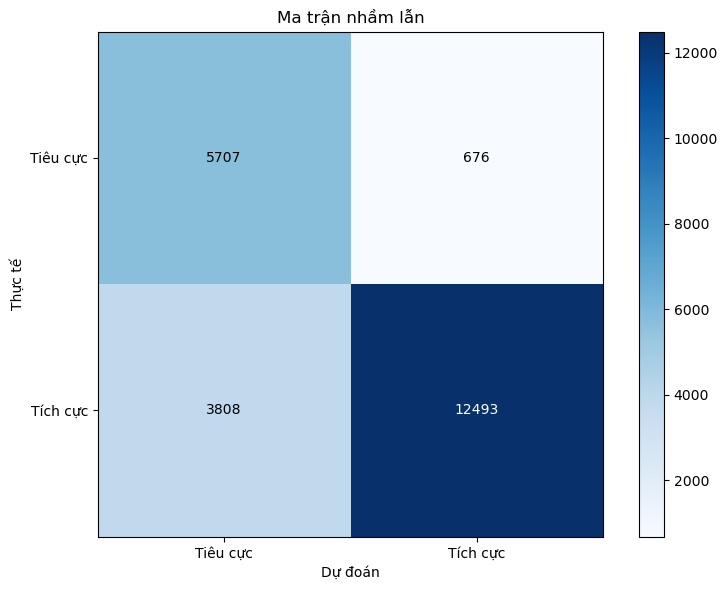

In [40]:
kq_test = model2.predict(text_ma_hoa)

# Convert one-hot encoded labels to binary labels
nhan_binary = np.argmax(nhan, axis=1)

acc_test = accuracy_score(nhan_binary, kq_test)
print(f"Độ chính xác của model: {acc_test* 100:.2f}%")

cm = confusion_matrix(nhan_binary, kq_test)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn')
plt.colorbar()

# Thêm số liệu vào các ô
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

# Chỉ cần định nghĩa labels một lần
labels = ['Tiêu cực', 'Tích cực']
plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()